# Esercitazione 12 - Riconoscimento delle immagini con reti neurali profonde e convoluzionali

## 1 Obiettivo

L'obiettivo di questa esercitazione è realizzare del codice in grado di riconoscere le dieci cifre 0-9 in delle immagini in cui queste sono scritte a mano.

A questo scopo verrà utilizzata sia una rete neurale profonda sia una rete neurale convoluzionale. Ne verranno quindi discusse analogie, differenze, potenzialità e limiti di ciascuna architettura.

## 2 Rete neurale profonda

In questa prima parte dell'esercitazione ho implementato il riconoscimento della scrittura delle 10 cifre utilizzando una rete neurale profonda. 
Nel paragrafo successivo è presente il codice che ho implementato, corredato di spiegazione dei vari passaggi e di alcune osservazioni riguardanti scelte progettuali e problemi che è stato necessario affrontare.

### 2.1 Implementazione

Innanzitutto importo i diversi moduli utilizzati. Le librerie necessarie per la realizzazione della rete neurale sono keras e tensorflow.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

Per poter allenare il modello è necessario disporre di un set di dati su cui effettuare l'allenamento e la validazione. Keras mette a disposizione il dataset `mnist` costituito da $7\cdot10^5$ immagini 28x28 in scala di grigi raffiguranti delle cifre da 0 a 9 scritte a mano con diverse calligrafie. Le immagini sono inoltre etichettate con il valore che vi è rappresentato, non sarebbe altrimenti possibile utilizzarle in applicazioni di questo tipo.

In [2]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


an example of a data point with label 4


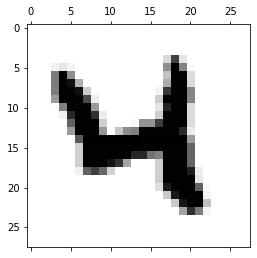

an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [3]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

print('an example of a data point with label', Y_train[20], 'before to_categorical ...')
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

Nella cella precedente viene formattato il dataset secondo le esigenze di keras. Viene inoltre mosttrato un esempio di questi dati e viene fornita una dimostrazione di utilizzo della funzione `keras.utils.to_categorical` che trasforma la label in un vettore binario in cui ogni cella rappresenta una diversa categoria. Questa funzione servirà per utilizzare la funzione di costo `categorical_crossentropy`.

Sono quindi pronto a creare il modello di rete neurale. Dopo aver importato le componenti necessarie viene definita una funzione che definisce la struttura della rete neurale profonda.

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

Come si può leggere dal codice viene costruita una rete neurale costituita da un layer di input da 400 neuroni, seguito da un layer nascosto da 100 neuroni e, infine, un layer costituito da 10 neuroni da cui verrà letta la classificazione.
Tra l'ultimo e il penultimo layer è presente un layer di dropout che casualmente spegne il 50% delle connessioni tra i due layer tra cui è posto. Questo avviene solamente durante la fase di allenamento. Quando poi il modello è pronto, durante la sua applicazione su nuovi dati tutte le connessioni vengono mantenute attive.

Si può notare come il numero di neuroni diminuisca da layer a layer. Questa scelta, insieme alla scelta di aggiungere il layer di dropout, è dovuta alla differente dimensione dei dati di input e di output: la rete deve cercare di condensare e riassumere tutta l'informazione che le viene fornita estraendone solo la componente importante per eseguire la categorizzazione.

La funzione di attivazione scelta per i neuroni interni è la `relu` che è una tra le più comunemente utilizzate. L'ultimo layer utilizza invece la `softmax`. Questa funzione di attivazione è specificatamente indicata per problemi di catalogazione in quanto fornisce valori in uscita a tutti i neuroni di output non negativi e tali che la loro somma sia pari a 1. Questo permette di interpretare l'output come una distribuzione di probabilità.

Nella cella successiva viene invece definita una funzione che permette di compilare il modello.

In [5]:
def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='nadam',
                  metrics=['acc'])
    return model

In questa fase sono due i parametri  che è importante specificare:
- l'ottimizzatore
- la funzione di costo

L'ottimmizatore è l'algoritmo utilizzato per variare i parametri della rete neurale in modo tale da ricercare il minimo della funzione di costo. Come già accennato nell'esercitazione precedente, ne esistono di diversi e la maggior parte di essi sono basati sull'algoritmo della discesa stocastica del gradiente.

In questo esercizio provo 3 diversi ottimizzatori diversi da quelli utilizzati nell'esercitazione 11:
- `Adadelta`: metodo di discesa stocastica del gradiente basato su un learning rate adattivo diverso per ogni direzione, implementato in modo tale da evitare che decresca troppo quando un parametro viene aggiornato molto frequentemente. È infatti una versione più robusta di `Adagrad` che previene questo problema e la necessità di settare un learning rate globale.

- `Nadam`: ottimizzatore `Adam` con momento di Nesterov in luogo del normale momento.

- `RMSprop`: Utilizza l'algoritmo RMSprop che mantiene una media delle lunghezze dei gradienti di alcuni step precedenti e divide il gradiente, in un passo della discesa, per la radice quadrata di questa media. Implementa inoltre anche un momento.

Come funzione di costo viene invece scelta la `categorical_crossentropy`:

$$
L(\vec y^{out})=-\frac{1}{N}\sum_{i=1}^{N}\big(y_i^{out}\cdot\log(y_i^{lab})\big)
$$

dove la sommatoria è eseguita sulle categorie e i valori $y^{out_i}$ sono i valori ottenuti in output dalla rete, ovvero le probabilità associate a ciascuna categoria. Per poter utilizzare questa funzione è necessario che le label dei dati abbiano la forma fornita dalla funzione `keras.utils.to_categorical()`.

Posso ora avviare l'allenamento del modello

In [6]:
# training parameters
batch_size = 32
epochs = 20
#identificativo per i vari file che vengono salvati. 
#quando si modifica un parametro modificare anche questo 
#così da avere nomi diversi per i file.
saving_id = '004'

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/20
1875/1875 [==============================] - 31s 11ms/step - loss: 0.4717 - acc: 0.8583 - val_loss: 0.1218 - val_acc: 0.9626
Epoch 2/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1202 - acc: 0.9657 - val_loss: 0.0916 - val_acc: 0.9712
Epoch 3/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0877 - acc: 0.9748 - val_loss: 0.0821 - val_acc: 0.9751
Epoch 4/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0670 - acc: 0.9797 - val_loss: 0.0873 - val_acc: 0.9738
Epoch 5/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0501 - acc: 0.9837 - val_loss: 0.0769 - val_acc: 0.9784
Epoch 6/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0443 - acc: 0.9866 - val_loss: 0.0832 - val_acc: 0.9792
Epoch 7/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0393 - acc: 0.9871 - val_loss: 0.0994 - val_acc: 0.9764
Epoch 8/20
1875/1875 [==========================

valutazione del modello

In [8]:
#ottengo il nome dell'ottimizzatore utilizzato
opt_str = str(model_DNN.optimizer)
nopt_str2 = str.split(opt_str, 'object')[0]
opt_name = str.split(nopt_str2, '.')[-1].strip()

#definisco nomi di file e directory
file_prefix = opt_name + saving_id
savedir = '../12/es12.1.output/'

Definisco quindi alcune variabili necessarie per salvare i risultati ottenuti

313/313 [==============================] - 1s 2ms/step - loss: 0.1196 - acc: 0.9812

Test loss: 0.11959399282932281
Test accuracy: 0.9811999797821045


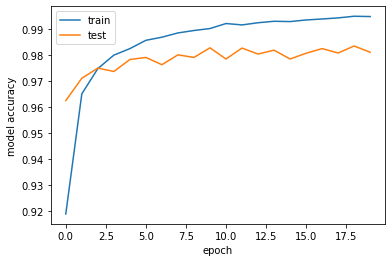

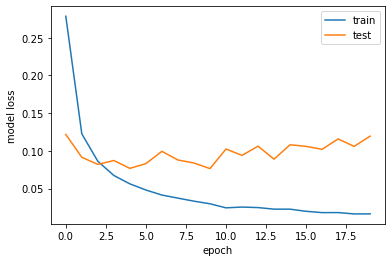

In [9]:
# evaluate model
score_loss, score_accuracy = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score_loss)
print('Test accuracy:', score_accuracy)

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig(savedir + file_prefix + '_acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig(savedir + file_prefix + '_loss.png')
plt.show()

Nella cella precedente ho eseguito l'applicazione della rete neurale al test set per valutare il modello allenato. Sono poi stampati i valori ottenuti per la funzione di costo e per l'accuratezza. 

L'accuratezza è una metrica utile per valutare il modello allenato, definita come la percentuale di valori predetti che corrispondono ai valori reali.

Sono inoltre mostrati anche gli andamenti di queste metriche in funzione delle epoche dell'allenamento. Questi grafici verranno discussi in seguito evidenziando le differenze tra i vari ottimizzatori.

In [10]:
#salvo alcune informazioni
output_f = open( savedir + file_prefix + '_info.txt', 'w');
output_f.write(opt_str + '\n')
output_f.write('epochs: ' + str(epochs)+'\n')
output_f.write('loss: ' + str(score_loss) + '\n')
output_f.write('accuracy: ' + str(score_accuracy) + '\n')
output_f.write('optimizer: ' + opt_name + '\n')
output_f.write(f'loss: {score_loss}\n')
output_f.write(f'accuracy : {score_accuracy}\n')
output_f.close()

Ho salvato su file alcune informazioni relative all'architettura appena simulata. 

Nella cella seguente è stata realizzata una applicazione del modello allenato ad alcuni valori estratti dal test set. L'unico scopo di queste righe è il fornire un riscontro visivo di ciò che predice la rete associandolo alla corrispondente immagine di input.

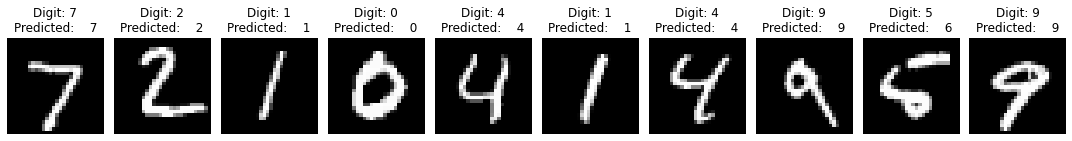

In [11]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.tight_layout()
plt.show()

### 2.2 Performance di diversi ottimizzatori

#### 2.2.1 Adadelta

<img src="../12/es12.1.output/Adadelta002_loss.png" align="left">
<img src="../12/es12.1.output/Adadelta002_acc.png" align="left">


Valori dopo 20 epoche:
- loss: 0.601
- accuracy: 0.874

Con questo primo ottimizzatore si può osservare come fino all'ultima epoca sia la funzione di costo sia l'accuracy continuino a migliorare. L'andamento di queste curve mi fa ipotizzare che l'allenamento si sarebbe potuto continuare ottenendo risultati migliori. Tuttavia il tempo di esecuzione è già abbastanza alto e, come si vedrà, altri ottimizzatori consentono con le sole 20 epoche di giungere a risultati più soddisfacenti. 
Posso quindi concludere che questo ottimizzatore sia troppo lento per questa applicazione.

#### 2.2.2 Nadam

<img src="../12/es12.1.output/Nadam001_loss.png" align="left">
<img src="../12/es12.1.output/Nadam001_acc.png" align="left">


Valori dopo 20 epoche:
- loss: 0.120
- accuracy: 0.981

Si nota invece in questo caso un andamento notevolmente diverso. La convergenza è avvenuta con velocità superiori e si è presto raggiunto un valore di saturazione per entrambe le funzioni.
Si può anche osservare un principio di overlearning in quanto la funzione di costo valutata sul test set ha nelle ultime epoche un andamento crescente, laddove se valutata sul training set questa continua a decrescere.

Tuttavia l'accuracy ottenuta rimane ottima assestandosi intorno al 98%.

#### 2.2.3 RMSprop

<img src="../12/es12.1.output/RMSprop003_loss.png" align="left">
<img src="../12/es12.1.output/RMSprop003_acc.png" align="left">


Valori dopo 20 epoche:
- loss: 0.396
- accuracy: 0.974

In questo caso si nota un allontanamento dal minimo trovato dopo circa 3 epoche. Vi è anche un sostanziale incremento del valore della funzione di costo valutata sul test set. L'accuracy mantiene invece valori circa costanti pari a quelli ottenuti dopo le 3 epoche.
Valutando il quadro complessivo posso concludere che tra i 3 ottimizzatori `Nadam` è quello che ha performato nel migliore dei modi con gli altri parametri che già erano stati fissati. Il modello allenato con questo ottimizzatore è quello che verrà utilizzato nella successiva applicazione.

### 2.3 Applicazione del modello

Ho quindi applicato il modello a 10 immagini di cifre scritte da me con gimp. Ho introdotto alcune peculiarità come ad esempio il non centramento della cifra all'interno della cella.

I risultati ottenuti dall'applicazione del modello sono i seguenti

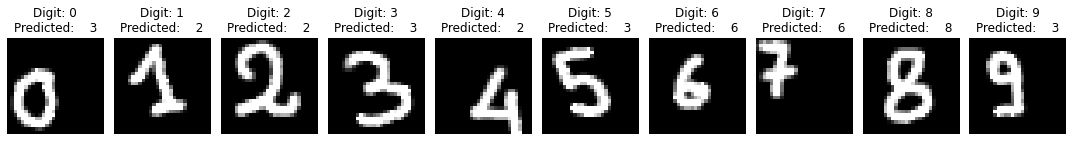

In [21]:
from PIL import Image
import os

my_X = []
for i in range(0,10):
    digit_filename = f"../12/{i}.png"
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    data = data.reshape(1,xdim*ydim)
    my_X.append(data)
    
my_X = np.array(my_X)
predictions = [model_DNN.predict(ele) for ele in my_X]

my_X = my_X.reshape(my_X.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(my_X[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(i, np.argmax(predictions[i])))    
    plt.axis('off') 
plt.tight_layout()
plt.show()

Su queste 10 immagini l'accuracy ottenuta è solo del 40%. Non sono state predette alcune cifre come lo 0 e il 7 che sono state decentrate. Si osserverà poi se con le stesse immagini la rete neurale convoluzionale fornisce risultati migliori.

## 3 Rete neurale convoluzionale

In questa seconda parte dell'esercizio ho invece implementato la risoluzione dello stesso problema mediante una rete neurale convoluzionale. Questo tipo di reti utilizza layers convoluzionali che eseguono una sorta di filtraggio dell'immagine per l'estrazione delle caratteristiche fondamentali.

Le varie tipologie di layers utilizzate verrano discusse in seguito. Lo scopo principale di un'architettura di questo tipo è quello di rendere la rete in grado di gestire dati che possono essere caratterizzati da simmetria traslazionale o di riscalamento. Questa rete dovrebbe essere migliore nel processare immagini in cui la cifra appare decentrata o di dimensioni diverse rispetto a quelle incontrate nel training set.

### 3.1 Implementazione

L'implementazione segue lo stesso schema dell'architettura precedente. La differenza fondamentale risiede nella scelta dei layer con cui costruire la rete.

Innanzitutto importo i moduli necessari e preparo i dati

In [13]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


Definisco quindi la funzione che crea il modello della rete. In questa funzione risiede la natura convoluzionale. La struttura che ho realizzato è caratterizzata dai seguenti layer:

- `Conv2D`: Questo Layer crea un kernel di convoluzione che viene poi applicato al layer di input producendo in output un tensore. Il comportamento di questo layer è chiaro dalla seguente figura, la feature map è il tensore restituito in output dal layer:
<img src="../12/conv2d.gif" width="400">

- `MaxPooling2D`: Sottocampiona l'input lungo le sue dimensioni spaziali prendendo il valore massimo entro una certa finetra descritta da `pool_size`. Questa finestra viene shiftata sull'immagine di input di `strides` nelle due direzioni. L'obiettivo di questo layer è la riduzione dei numerosi dati forniti dall'immagine con lo scopo di estrarne solamente le informazioni principali.

- `Flatten`: è un layer che linearizza i dati provenienti dal layer precedente disposti su più dimensioni trasformandoli in una sola sequenza unidimensionale.

Le altre tipologie di Layer sono già state usate nell'implementazione della rete neurale profonda.

In [14]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dense(32))
    model.add(Dropout(0.7))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

In questo caso la funzione `create_CNN()` esegue anche la compilazione del modello. È stata usata sempre la funzione di costo `categorical_crossentropy` che è la scelta ottimale per problemi di catalogazione.
L'ottimizzatore scelto è invece il puro algoritmo di discesa stocastica del gradiente.

In [15]:
m = create_CNN()
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 10)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 11, 11, 32)        352       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                61968     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

A questo punto posso avviare l'allenamento del modello. Vengono utilizzate poche epoche per via della complessità del modello che rende l'allenamento computazionalmente costoso e determina un alto rischio di incorrere in overlearning.

In [16]:
# training parameters
batch_size = 32
epochs = 10

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
1875/1875 [==============================] - 23s 11ms/step - loss: 1.1169 - acc: 0.6236 - val_loss: 0.1757 - val_acc: 0.9513
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2135 - acc: 0.9350 - val_loss: 0.1041 - val_acc: 0.9683
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1487 - acc: 0.9558 - val_loss: 0.0786 - val_acc: 0.9761
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1214 - acc: 0.9639 - val_loss: 0.0649 - val_acc: 0.9792
Epoch 5/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1018 - acc: 0.9687 - val_loss: 0.0595 - val_acc: 0.9802
Epoch 6/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0952 - acc: 0.9703 - val_loss: 0.0546 - val_acc: 0.9808
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0875 - acc: 0.9726 - val_loss: 0.0503 - val_acc: 0.9838
Epoch 8/10
1875/1875 [==========================

Il modello allenato svolge il compito prefissato in maniera soddisfacente, come si può concludere dai valori ottenuti dalla valutazione sul test set della funzione di costo e dell'accuratezza.

Lo storico di queste funzioni valutate ad ogni epoca, nella prima esecuzione con sole 5 epoche, suggerivano che si sarebbero potuti ottenere risultati migliori continuando l'allenamento in quanto sia l'accuratezza sia la loss mostravano un andamento non ancora in saturazione. Inoltre l'accuratezza valutata sul test set è nelle prime epoche maggiore di quella valutata sul training set, indice anch'esso della possibilità di continuare l'allenamento almeno fino a quando non avviene l'inversione tra le due funzioni.

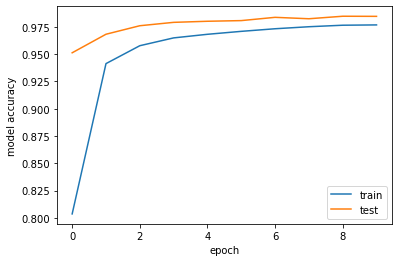

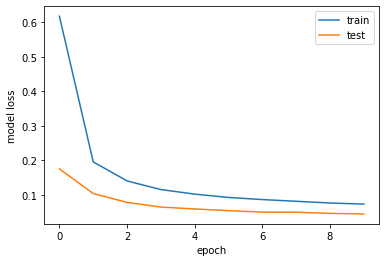

In [17]:
# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

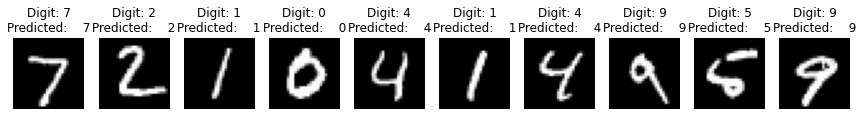

In [18]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

In questa immagine è presentata l'applicazione del modello allenato ad un sottoinsieme del test set. Lo scopo è ancora quello di mostrare l'accuratezza del modello avendo modo di osservare i dati di input che la rete ha processato.

### 3.2 Applicazione del modello

Come per il punto precedente, anche in questo caso ho utilizzato il modello allenato applicandolo ad alcune cifre scritte a mano da me

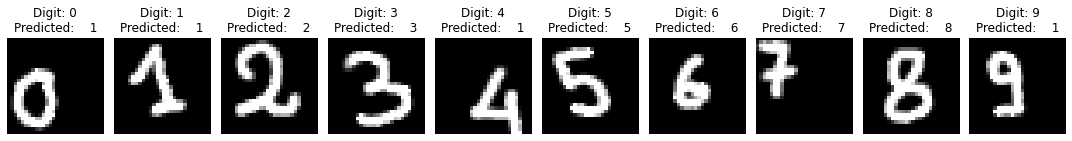

In [20]:
from PIL import Image
import os

my_X = []
for i in range(0,10):
    digit_filename = f"../12/{i}.png"
    digit_in = Image.open(digit_filename).convert('L')
    
    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    data = data.reshape(1,xdim,ydim,1)
    my_X.append(data)
    
my_X = np.array(my_X)
predictions = [model_CNN.predict(ele) for ele in my_X]

my_X = my_X.reshape(my_X.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(my_X[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(i, np.argmax(predictions[i])))    
    plt.axis('off') 
plt.tight_layout()
plt.show()

Con questo nuovo modello l'accuratezza sulle cifre scritte da me è salita al 70%. si può apprezzare come ad esempio il 7 sia stato predetto correttamente nonostante fosse decentrato. L'analisi della stessa immagine era invece fallita con la rete neurale profonda.
Altre cifre invece che erano state scritte decentrate non sono state riconosciute. Il modello deve essere ancora migliorato per analizzare meglio dati con piccole differenze dal set di allenamento.